In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows = 4000

# Shopify Winter 2021 Data Science Challenge

**By: Kanika Chopra**

This notebook will be to go through the 100 sneaker shops and analyse the order value. We want to understand why over a 30 day window, the average order value (AOV) is $3145.13 and determine a more accurate metric. 


Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
What metric would you report for this dataset?
What is its value?


## Loading the Data

First, we need to load the data that we are using for the 100 sneaker shops. 

In [3]:
shoes = pd.read_csv('/content/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')

In [4]:
shoes.columns

Index(['order_id', 'shop_id', 'user_id', 'order_amount', 'total_items',
       'payment_method', 'created_at'],
      dtype='object')

Next, we want to do some data preprocessing on the dates before we can do the exploratory data analysis on the data to understand what kind of data we are working with.

## Data Preprocessing

In [5]:
shoes['created_at'].head()

0    2017-03-13 12:36:56
1    2017-03-03 17:38:52
2     2017-03-14 4:23:56
3    2017-03-26 12:43:37
4     2017-03-01 4:35:11
Name: created_at, dtype: object

We want to split up the created date by year, month and day. We want to keep the created_at column in case we want to reference it later so we create new columns for these three categories.

In [6]:
shoes['year'] = shoes['created_at'].apply(lambda x: x[:4])
shoes['month'] = shoes['created_at'].apply(lambda x: x[5:7])
shoes['day'] = shoes['created_at'].apply(lambda x: x[8:10])

## Exploratory Data Analysis

In [7]:
shoes.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,year,month,day
0,1,53,746,224,2,cash,2017-03-13 12:36:56,2017,03,13
1,2,92,925,90,1,cash,2017-03-03 17:38:52,2017,03,03
2,3,44,861,144,1,cash,2017-03-14 4:23:56,2017,03,14
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,2017,03,26
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,2017,03,01


In [8]:
shoes.shape

(5000, 10)

We see that the columns we have are order ID, shop ID, user ID, order amount, total items, payment method and the date the order was created at. We have 7 columns, and 5000 rows so 5000 different orders. We'll want to investigate the different columns to see where the error may lie.

### Dates 
This is to understand what year and month these purchases are happening in.

In [9]:
shoes['year'].value_counts()

2017    5000
Name: year, dtype: int64

In [10]:
shoes['month'].value_counts()

03    5000
Name: month, dtype: int64

In [11]:
# Get the days dataframe
days = pd.DataFrame(shoes['day'].value_counts())
days.reset_index(inplace=True)
days.columns = ['day', 'count']
days.sort_values(by='day', inplace=True)

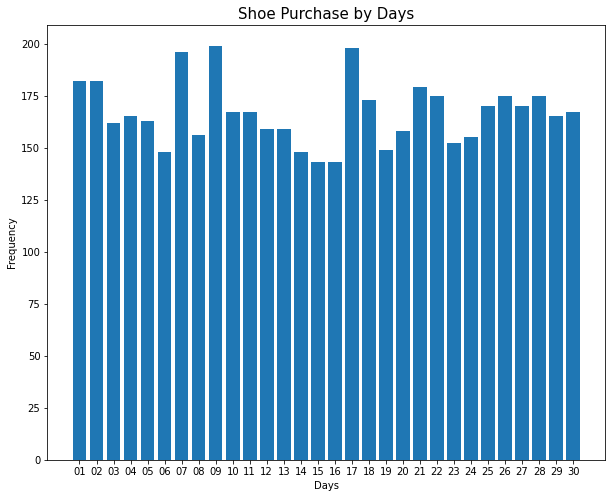

In [12]:
# Plot the bar graph of days 
plt.figure(figsize=[10,8])
plt.bar(days['day'], days['count'])
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Shoe Purchase by Days',fontsize=15)
plt.show()

It doesn't seem like there is a trend with the days that the purchases are made, they seem to be randomly distributed. Each day has a similar number of orders with a few exceptions; however, this is all within the 30 day span so we should look for outliers.

### User ID 

We begin by looking to see if there are any user IDs who have a large number of orders.

In [13]:
shoes.user_id.value_counts().head()

718    28
868    27
847    26
791    26
727    25
Name: user_id, dtype: int64

We can see that there are some cases where a user is placing orders 28 times. This is something we will keep in mind in case there is one user that is making large purchases and driving up the AOV price.

### Total Items

In [14]:
shoes.total_items.value_counts()

2       1832
1       1830
3        941
4        293
5         77
2000      17
6          9
8          1
Name: total_items, dtype: int64

We can see that as the number of items increases, the quantity ordered decreases which makes sense as most customers would prefer to buy 1 or 2 pairs of shoes. However, we can see that there are 17 cases where 2000 shoes are bought and this is likely increasing the AOV. We'll want to investigate this further as this seems like a huge outlier in comparison to the other total items.

We can start by trying to understand if this is one user that is repeatedly buying these shoes, or many users. 

## Investigating the 2000 Shoes

We want to investigate this case of 2000 shoes and determine if this is an outlier. This may be the outlier causing an increase in the AOV.

In [15]:
shoes2000 = shoes[shoes['total_items'] == 2000]

shoes2000.user_id.value_counts()

607    17
Name: user_id, dtype: int64

From this, we can see that user id 607 is the only customer purchasing 2000 pairs of shoes. 

In [16]:
shoes2000.payment_method.value_counts()

credit_card    17
Name: payment_method, dtype: int64

These shoes are all paid for by credit card.

In [17]:
shoes2000['order_amount'].value_counts()

704000    17
Name: order_amount, dtype: int64

It seems that each time, the order amount is the same as well so they are buying the same amount of shoes. Let's see if they are getting them all from one shop as this would make sense if the cost of the shoes is the same each time.

In [18]:
shoes2000['shop_id'].value_counts()

42    17
Name: shop_id, dtype: int64

Each of the shoes is clearly from the same shop, which means they are selling the one sneaker 2000 times to this customer; hence, the cost is consistent each time. 

Since this is repeatedly happening within the 30 days, this would be increasing the AOV significantly. This is the error that we have so we want to figure out a better way to handle this data and determine an appropriate metric.

## New Metric

To determine the metric, we want to consider a few options and determine the most optimal metric. 

We will consider the following metrics:
1. Remove the cases with 2000 total items and calculating the mean
2. Remove the cases with 2000 total items and calculating the median
3. Calculating the median of all the cases

In [19]:
# Remove the 2000 values 
shoes_clean = shoes[shoes['total_items'] != 2000]

len(shoes_clean)

4983

In [20]:
shoes_clean.total_items.value_counts()

2    1832
1    1830
3     941
4     293
5      77
6       9
8       1
Name: total_items, dtype: int64

The shoes here are not a very large amount. The largest amount is 8 shoes and that is only one purchase. Let's check the price of that so we can determine if the mean or median is a better metric.

### Mean

In [21]:
# Mean before any changes
print('Before: ', np.mean(shoes.order_amount))

# Mean after changes
print('After: ', np.mean(shoes_clean.order_amount))

Before:  3145.128
After:  754.0919125025085


The mean before removing the 2000 order item values is significnatly higher. It is more than four times the mean after the 2000 order item values are removed. This mean is a more accurate measure.

### Median

In [22]:
# Median before any changes
print('Before: ', np.median(shoes.order_amount))

# Median after changes
print('After: ', np.median(shoes_clean.order_amount))

Before:  284.0
After:  284.0


The median does not change whether we remove the outliers or not. The median is a more robust measure of location so this is a good metric of cost.

### Summary Statistics

In [23]:
shoes.order_amount.describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

In [24]:
shoes_clean.order_amount.describe()

count      4983.000000
mean        754.091913
std        5314.092293
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      154350.000000
Name: order_amount, dtype: float64

From the summary statistics, we can see that up until the 75% quantile, the value is $390. 

Thus, the mean even after removing the values is too high. Therefore, we conclude that the median is the best metric to be used instead of the AOV. The median here is $284 for the 30 day period.

## Summary

This section will summarize the answers to the data analysis part of the question.

**1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. **

The error in the AOV is that there are outlier with the total number of items which is greatly inflating the AOV value. There are 17 cases where the same customer buys 2000 shoes. This is either an error in inputting the data or an odd case of someone buying a large volume of shoes. In either case, it is an outlier and thus we should either find a more robust measure of location or remove these values.

**2. What metric would you report for this dataset?**

For this dataset, the analysis has shown that we need a more robust measure of location to get an accurate estimate of the order value. Thus, we use the median of the full dataset. 

**3. What is its value?**

The value of the median of the full dataset is $284.00. 
